<a href="https://colab.research.google.com/github/alixintong/btt-ai-know-your-customer/blob/jess/bounding_box.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# this cell allows access to our folder

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_path = '/content/gdrive/MyDrive/BTTAI_AmericanExpress1'

Mounted at /content/drive


## For datasheet frames

In [2]:
# cell for imports - add as needed
import torch 
import cv2
import numpy as np 
import pandas as pd
import os, os.path
import re
from fastai.vision.all import *

In [3]:
# for reference
#   - fastai segmentation: https://walkwithfastai.com/Segmentation
#   - fastai object detection: https://walkwithfastai.com/Object_Detection

### Data

In [4]:
path = '/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames'

files = get_image_files(path + "/datasheet001_frames")
len(files)

214

In [5]:
# import bounding box datasheet csv
# use datasheet001 as csv instead of xml
url='https://drive.google.com/file/d/1lUoBf1rwPXPlI9Zg2lDzwV4ODtsGJ4u2/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head()

,point/0/_name,point/0/_x,point/0/_y,point/1/_name,point/1/_x,point/1/_y,point/2/_name,point/2/_x,point/2/_y,point/3/_name,point/3/_x,point/3/_y,_index,_rejected
0,bl,716.625,805.609,tl,737.377,201.383,tr,1180.71,199.127,br,1259.02,791.942,1,False
1,bl,714.326,806.309,tl,736.330,202.300,tr,1179.74,200.028,br,1257.21,792.161,2,False
2,bl,713.031,804.811,tl,734.431,201.449,tr,1177.81,199.795,br,1255.42,791.291,3,False
3,bl,713.845,802.659,tl,734.423,198.474,tr,1177.79,196.852,br,1256.72,789.631,4,False
4,bl,713.088,802.830,tl,734.675,195.678,tr,1179.99,194.057,br,1259.35,790.289,5,False


In [6]:
df["document"] = df["_rejected"].apply(lambda x: not x)

In [7]:
df = df.drop('_rejected', axis = 1)
df.head()

,point/0/_name,point/0/_x,point/0/_y,point/1/_name,point/1/_x,point/1/_y,point/2/_name,point/2/_x,point/2/_y,point/3/_name,point/3/_x,point/3/_y,_index,document
0,bl,716.625,805.609,tl,737.377,201.383,tr,1180.71,199.127,br,1259.02,791.942,1,True
1,bl,714.326,806.309,tl,736.330,202.300,tr,1179.74,200.028,br,1257.21,792.161,2,True
2,bl,713.031,804.811,tl,734.431,201.449,tr,1177.81,199.795,br,1255.42,791.291,3,True
3,bl,713.845,802.659,tl,734.423,198.474,tr,1177.79,196.852,br,1256.72,789.631,4,True
4,bl,713.088,802.830,tl,734.675,195.678,tr,1179.99,194.057,br,1259.35,790.289,5,True


In [8]:
def get_coordinates(row_data):
  x1 = min(row_data[1], row_data[4], row_data[7], row_data[10])
  y1 = min(row_data[2], row_data[5], row_data[8], row_data[11])
  x2 = max(row_data[1], row_data[4], row_data[7], row_data[10])
  y2 = max(row_data[2], row_data[5], row_data[8], row_data[11])
  bb_cd = [x1, y1, x2, y2] 
  return bb_cd

In [9]:
bb = []
bb.append(df.apply(lambda row: get_coordinates(row), axis = 1))

In [10]:
bb = np.array(bb)
bb = bb.flatten()

In [11]:
bb = list(bb)

In [12]:
df_bb = pd.DataFrame(data=bb, columns=['x1', 'y1', 'x2', 'y2'])

In [13]:
df_bb.head()

,x1,y1,x2,y2
0,716.625,199.127,1259.02,805.609
1,714.326,200.028,1257.21,806.309
2,713.031,199.795,1255.42,804.811
3,713.845,196.852,1256.72,802.659
4,713.088,194.057,1259.35,802.830


In [14]:
df_bb['document'] = df['document']
df_bb.head() # df_bb would be the labels of bounding boxes

,x1,y1,x2,y2,document
0,716.625,199.127,1259.02,805.609,True
1,714.326,200.028,1257.21,806.309,True
2,713.031,199.795,1255.42,804.811,True
3,713.845,196.852,1256.72,802.659,True
4,713.088,194.057,1259.35,802.830,True


In [15]:
# get image names
os.chdir('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames')
imgs = os.listdir()

In [16]:
bbox = []
for i in range(0,214):
  e = [list(df_bb.iloc[i,0:4]), [df_bb.iloc[i,4]]]
  bbox.append(e)

In [17]:
# use a dictionary to quickly look up a corresponding image to it's label
img2bbox = dict(zip(imgs, bbox))

In [31]:
# a getter function
getters = [lambda o: o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]] # o is the input image name

In [32]:
# for transforms later
item_tfms = [Resize(128, method='pad'),] 
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

In [33]:
def get_train_imgs(noop): return imgs # simply return the images

In [34]:
frames = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock), # define pre-defined problem domains: images, bb, label bb
                 splitter=RandomSplitter(), 
                 get_items=get_train_imgs, 
                 getters=getters, # getters applied to results of get_items
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [ ]:
frames.summary(os.getcwd())

In [36]:
files = get_image_files(os.getcwd())

In [37]:
files[:5]

(#5) [Path('/content/drive/.shortcut-targets-by-id/17C-FeV89lWfoxThc1mu8REz8adMDfNfP/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames/datasheet001_frames_00001.jpg'),Path('/content/drive/.shortcut-targets-by-id/17C-FeV89lWfoxThc1mu8REz8adMDfNfP/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames/datasheet001_frames_00002.jpg'),Path('/content/drive/.shortcut-targets-by-id/17C-FeV89lWfoxThc1mu8REz8adMDfNfP/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames/datasheet001_frames_00003.jpg'),Path('/content/drive/.shortcut-targets-by-id/17C-FeV89lWfoxThc1mu8REz8adMDfNfP/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames/datasheet001_frames_00004.jpg'),Path('/content/drive/.shortcut-targets-by-id/17C-FeV89lWfoxThc1mu8REz8adMDfNfP/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames/datasheet001_frames_00005.jpg')]

In [38]:
dls = frames.dataloaders(files)

In [ ]:
#dls.c = 20 

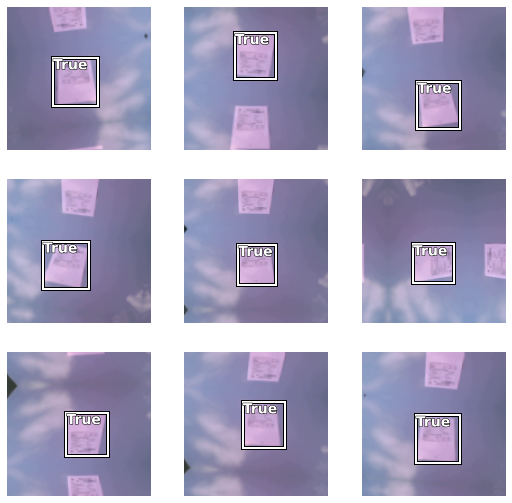

In [39]:
dls.show_batch()

### Model

In [ ]:
from wwf.vision.object_detection import * # use RetinaNet

In [ ]:
encoder = create_body(resnet34, pretrained=True)